Mask areas with high uncertainty and plot the observation count 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import xesmf
import cf_xarray
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Observation count
obc_ds = xr.open_dataset('/g/data/w40/rl5183/obscount_20CRv3_rg.nc')
obc = obc_ds.obcount.sel(time='2015-12')
# HDI
hdi_ds = xr.open_dataset('/g/data/w40/rl5183/HDI_1990_2015_1x1.nc')
hdi = hdi_ds.HDI.sel(time=2015)
# Mean precip correlation
mean_corr_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/precip/monthly_precip_correlations_all_members.nc')
mean_corr = mean_corr_ds.__xarray_dataarray_variable__
# Rx1 correlation
rx1_corr_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/precip/Rx1day_correlations_all_members_1901_2015.nc')
rx1_corr = rx1_corr_ds.__xarray_dataarray_variable__
# Mean precipitation ensemble spread
mean_std = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/prate_ensemble_std_corr_1901_2015.nc')
# Rx1 ensemble spread
rx1_std = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/Rx1day_ensemble_std_corr_1901_2015.nc')

In [3]:
# Set up regridder to regrid standrd deviation onto 2x2 to match obs count
from_bnds = mean_corr_ds.cf.add_bounds(['latitude','longitude'])
to_bnds = obc_ds.cf.add_bounds(['lat','lon'])
regrid_mean = xesmf.Regridder(from_bnds, to_bnds, method='conservative_normed')

In [4]:
# Set up regridder to regrid standrd deviation onto 2x2 to match obs count
from_bnds = rx1_corr_ds.cf.add_bounds(['latitude','longitude'])
to_bnds = obc_ds.cf.add_bounds(['lat','lon'])
regrid_ex = xesmf.Regridder(from_bnds, to_bnds, method='conservative_normed')

In [5]:
# Land mask for observation count data from HDI on 2x2 grid
hdi_2x2_ds = xr.open_dataset('/g/data/w40/rl5183/HDI_1990_2015_2x2.nc')
hdi_2x2 = hdi_2x2_ds.HDI.sel(time=2015)
obc=obc.where(np.isfinite(hdi_2x2))

In [7]:
mean_std_2x2 = regrid_mean(mean_std)
rx1_std_2x2 = regrid_ex(rx1_std)

In [58]:
mean_std_high = mean_std_2x2.where(mean_std_2x2>0.05)
rx1_std_high = rx1_std_2x2.where(rx1_std_2x2>0.07)

In [59]:
obc_2d = obc.mean(dim='time')

In [60]:
mean_mask = obc_2d * mean_std_high.sel(month=11)
ex_mask = obc_2d * rx1_std_high.sel(month=11)

In [61]:
obc_mask_mean = obc_2d.where(np.isfinite(mean_mask))
obc_mask_ex = obc_2d.where(np.isfinite(ex_mask))
mean_std_mask = mean_std_high.where(np.isfinite(mean_mask))
rx1_std_mask = rx1_std_high.where(np.isfinite(ex_mask))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: U

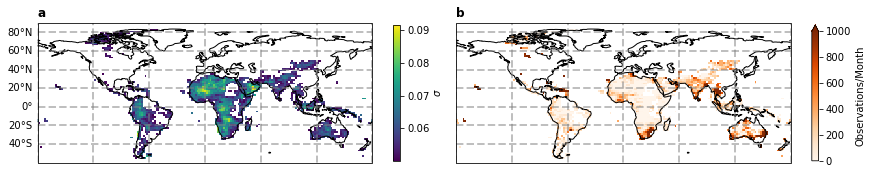

In [62]:
fig = plt.figure(figsize=(15,5))

# MEAN STD
ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
C = mean_std_mask.sel(month=11).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
cbar = plt.colorbar(C, ax=ax, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel(''r'$\sigma$', fontsize=10)
ax.set_title('a', loc='left', fontweight='bold')
ax.set_title('')

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# OBSERVATION COUNT
ax = fig.add_subplot(122, projection=ccrs.PlateCarree())
C = obc_mask_mean.plot(ax=ax, vmin=0, vmax=1000, cmap='Oranges', alpha=1, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
cbar = plt.colorbar(C, ax=ax, extend='max', shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('Observations/Month', fontsize=10)
ax.set_title('b', loc='left', fontweight='bold')
ax.set_title('')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

fig.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('paper_fig_supp_2.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)